In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), os.pardir))

import pandas as pd
import numpy as np
from onemap_client import OneMapClient
# from scipy.optimize import minimize
import time
import pyproj
import math

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
email = os.environ['ONE_MAP_API_EMAIL']
password = os.environ['ONE_MAP_API_PASSWORD']

Client = OneMapClient(email, password)
token = Client.get_token(email, password)

In [3]:
def cost_fn(time, freq):
    # We should change this to scale accordingly
    return np.exp(time)*freq

In [4]:
def get_travelling_time(start, end, client):
    # status = 'progress'
    # while status=='progress':
    journey = client.get_route(start, end, route_type='drive')
    if 'route_summary' not in journey:
        print(journey)
    # print(journey['route_summary']['total_time']/60/60)

    return journey['route_summary']['total_time']/60/60, journey['route_summary']['total_distance']

In [5]:
def get_mid_point(locations):
    coors = np.array([x['coor'] for x in locations])
    freq = np.array([x['freq'] for x in locations])
    midpoint = np.average(coors, axis=0, weights=freq)
    return midpoint

In [6]:
def valid_location(coor):
    locations = Client.reverse_geocode_WGS84(coor, buffer=0)
    print(f'{coor}: {locations}')
    return 1 if len(locations['GeocodeInfo'])==0 else 0

In [7]:
def objective_func(locations, cur):
    total_cost = 0
    individual_costs = {}
    for location in locations:
        coor = location['coor']
        freq = location['freq']
        time, distance = get_travelling_time(coor, cur, Client)
        cost = cost_fn(time,freq)
        total_cost += cost
        individual_costs[tuple(coor)] = cost
        
    print(f'Total Cost: {total_cost}')
    return total_cost, individual_costs


In [8]:
def get_direction(ind_costs, origin):
    locations = list(ind_costs.keys())
    costs = np.array([ind_costs[x] for x in locations]).reshape(3,1)
    locations = np.array(locations)
    origin = np.array(origin)

    geodesic = pyproj.Geod(ellps='WGS84')
    bearings = []
    for location in locations:
        fwd_azimuth,back_azimuth,distance = geodesic.inv(origin[1], origin[0], location[1], location[0])
        bearings.append(fwd_azimuth)
        # print(f'start:{origin}, end:{location}, bearing:{fwd_azimuth}')

    bearings = np.array(bearings).reshape(3,1)
    # print(bearings)
    v_cost_vectors =  costs * np.cos(bearings*np.pi/180)
    # print(v_cost_vectors)
    h_cost_vectors = costs * np.sin(bearings*np.pi/180)
    # print(h_cost_vectors)
    cost_vectors = np.hstack([v_cost_vectors, h_cost_vectors])
    # print(cost_vectors)
    sum_cost_vectors = np.sum(cost_vectors, axis=0)
    print(f'Resultant Cost:{sum_cost_vectors}')

    resultant_bearing = np.arctan(abs(sum_cost_vectors[0] / sum_cost_vectors[1]))*180/np.pi

    if sum_cost_vectors[0]>=0:
        if sum_cost_vectors[1]>=0:
            return resultant_bearing
        else:
            return 360-resultant_bearing
    else:
        if sum_cost_vectors[1]>=0:
            return 90+resultant_bearing
        else:
            return 180+resultant_bearing

In [21]:
from geographiclib.constants import Constants
from geographiclib.geodesic import Geodesic

def update_point(cur, bearings, distance_to_move_km=2):
    geodesic = pyproj.Geod(ellps='WGS84')
    long, lat, back_azimuth = geodesic.fwd(cur[1], cur[0], bearings, distance_to_move_km*1000)

    return lat,long

In [36]:
def optimise(locations, iterations=10):
    point = get_mid_point(locations)
    coors = np.array([x['coor'] for x in locations])
    bounds = ((np.min(coors[:,0]), np.max(coors[:,0])), (np.min(coors[:,1]), np.max(coors[:,1])))

    results = {'coor': [], 'total_cost': [], 'ind_costs': []}
    early_stop_count = 0
    lowest_cost = float('inf')
    for iter in range(iterations):
        results['coor'].append(point)
        costs, ind_costs = objective_func(locations, point)
        results['total_cost'].append(costs); results['ind_costs'].append(ind_costs)

        if lowest_cost>costs:
            early_stop_count = 0
            lowest_cost = costs
        else:
            early_stop_count+=1
        if early_stop_count==5:
            break

        update_bearings = get_direction(ind_costs, point)
        point = update_point(point, update_bearings)
        
    lowest_cost_idx = np.argmin(results['total_cost'])
    best_point = results['coor'][lowest_cost_idx]
    return best_point, results

In [37]:
locations = [
    # Changi Airport
    {'coor': [1.334961708552094, 103.96292017145929], 'freq': 1},
    # Murai Camp
    {'coor': [1.3869972483354562, 103.70085045003314], 'freq': 7},
    # Clarke Quay
    {'coor': [1.2929040296020744, 103.84729261914465], 'freq': 7}
]

In [38]:
optimised, results = optimise(locations, iterations=20)

Total Cost: 22.34981046998006
Resultant Cost:[-1.1246741   0.49908395]
103.79395077732403, 103.79395077732403
1.3230854521954651, 1.3230854521954651
Total Cost: 22.661115881225456
Resultant Cost:[1.7259388  0.78879763]
103.81029577818956, 103.81029577818956
1.3306037660058188, 1.3306037660058185
Total Cost: 22.919795434680587
Resultant Cost:[-1.67992876 -1.65484054]
103.79749310409271, 103.79749310409271
1.3179106640760383, 1.3179106640760383
Total Cost: 22.60786809217199
Resultant Cost:[2.80682505 0.43703726]
103.81525018854389, 103.81525018854389
1.3206933552936384, 1.3206933552936384
Total Cost: 22.564819315616603
Resultant Cost:[ 0.20947764 -1.92522474]
103.81330627437359, 103.81330627437359
1.338674520549589, 1.3386745205495891
Total Cost: 22.43569015678564


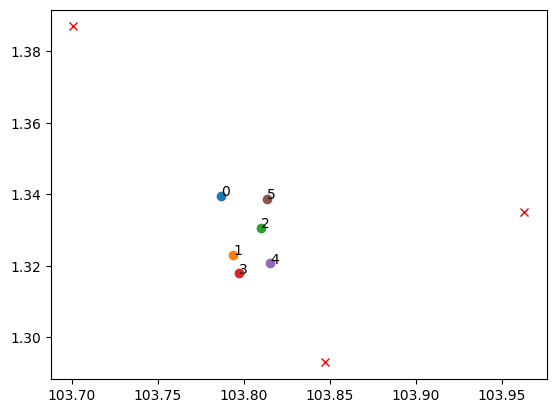

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot([x['coor'][1] for x in locations],[x['coor'][0] for x in locations], linestyle='None', marker='x', color='r')
for i in range(len(results['coor'])):
    ax.plot(results['coor'][i][1], results['coor'][i][0], linestyle='None', marker='o')
    ax.annotate(i, (results['coor'][i][1], results['coor'][i][0]))
plt.show()

In [20]:
results['ind_costs']

[{(1.334961708552094, 103.96292017145929): 1.705078432444398,
  (1.3869972483354562, 103.70085045003314): 10.533085047071848,
  (1.2929040296020744, 103.84729261914465): 10.111646990463814},
 {(1.334961708552094, 103.96292017145929): 1.665753840086666,
  (1.3869972483354562, 103.70085045003314): 11.293682317100641,
  (1.2929040296020744, 103.84729261914465): 9.701679724038149},
 {(1.334961708552094, 103.96292017145929): 1.6834299236066137,
  (1.3869972483354562, 103.70085045003314): 11.464364467708386,
  (1.2929040296020744, 103.84729261914465): 9.772001043365586},
 {(1.334961708552094, 103.96292017145929): 1.6932786289574784,
  (1.3869972483354562, 103.70085045003314): 11.67323994417567,
  (1.2929040296020744, 103.84729261914465): 9.241349519038842},
 {(1.334961708552094, 103.96292017145929): 1.5818754093795897,
  (1.3869972483354562, 103.70085045003314): 11.942181729928256,
  (1.2929040296020744, 103.84729261914465): 9.040762176308759},
 {(1.334961708552094, 103.96292017145929): 1.63